In [436]:
import os
import time
import numpy as np
import pandas as pd
from seaborn import countplot,lineplot, barplot
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix


from fastai import *
from fastai.tabular import *
from fastai.basic_data import DataBunch
from tqdm import tqdm_notebook

from bayes_opt import BayesianOptimization
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

In [437]:
tr = pd.read_csv('../input/X_train.csv')
te = pd.read_csv('../input/X_test.csv')
target = pd.read_csv('../input/y_train.csv')
ss = pd.read_csv('../input/sample_submission.csv')

In [438]:
tr.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [439]:
tr.shape, te.shape

((487680, 13), (488448, 13))

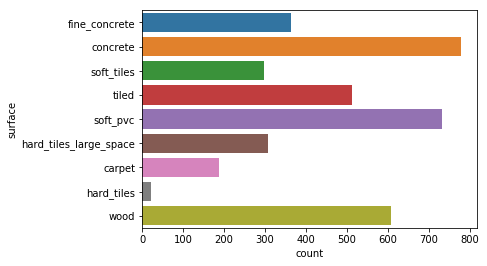

In [440]:
countplot(y = 'surface', data = target)
plt.show()

We need to classify on which surface our robot is standing.

So, its a simple classification task. Multi-class to be specific.

In [441]:
len(tr.measurement_number.value_counts())

128

What's that?
Each series has 128 measurements. 

In [442]:
tr.shape[0] / 128, te.shape[0] / 128

(3810.0, 3816.0)

So, we have 3810 train series, and 3816 test series.
Let's engineer some features!

## Feature Engineering

In [443]:
def quaternion_to_euler(x, y, z, w):
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

In [444]:
def fe_step0 (actual):
    
    # https://www.mathworks.com/help/aeroblks/quaternionnorm.html
    # https://www.mathworks.com/help/aeroblks/quaternionmodulus.html
    # https://www.mathworks.com/help/aeroblks/quaternionnormalize.html
        
    actual['norm_quat'] = (actual['orientation_X']**2 + actual['orientation_Y']**2 + actual['orientation_Z']**2 + actual['orientation_W']**2)
    actual['mod_quat'] = (actual['norm_quat'])**0.5
    actual['norm_X'] = actual['orientation_X'] / actual['mod_quat']
    actual['norm_Y'] = actual['orientation_Y'] / actual['mod_quat']
    actual['norm_Z'] = actual['orientation_Z'] / actual['mod_quat']
    actual['norm_W'] = actual['orientation_W'] / actual['mod_quat']
    
    return actual

def fe_step1 (actual):
    """Quaternions to Euler Angles"""
    
    x, y, z, w = actual['norm_X'].tolist(), actual['norm_Y'].tolist(), actual['norm_Z'].tolist(), actual['norm_W'].tolist()
    nx, ny, nz = [], [], []
    for i in range(len(x)):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx.append(xx)
        ny.append(yy)
        nz.append(zz)
    
    actual['euler_x'] = nx
    actual['euler_y'] = ny
    actual['euler_z'] = nz
    return actual

In [445]:
%%time
tr = fe_step0(tr)
te = fe_step0(te)

tr = fe_step1(tr)
te = fe_step1(te)

CPU times: user 2.1 s, sys: 112 ms, total: 2.21 s
Wall time: 2.11 s


In [446]:
def fe(data):
    
    df = pd.DataFrame()
    data['totl_anglr_vel'] = (data['angular_velocity_X']**2 + data['angular_velocity_Y']**2 +
                             data['angular_velocity_Z'])** 0.5
    data['totl_linr_acc'] = (data['linear_acceleration_X']**2 + data['linear_acceleration_Y']**2 +
                             data['linear_acceleration_Z'])**0.5
    data['totl_xyz'] = (data['orientation_X']**2 + data['orientation_Y']**2 +
                             data['orientation_Z'])**0.5
   
    data['acc_vs_vel'] = data['totl_linr_acc'] / data['totl_anglr_vel']
    
    for col in data.columns:
        if col in ['row_id','series_id','measurement_number', 'group_id']:
            continue
        if col in ['surface']:
            df[col] = data
        df[col + '_mean'] = data.groupby(['series_id'])[col].mean()
        df[col + '_median'] = data.groupby(['series_id'])[col].median()
        df[col + '_max'] = data.groupby(['series_id'])[col].max()
        df[col + '_min'] = data.groupby(['series_id'])[col].min()
        df[col + '_std'] = data.groupby(['series_id'])[col].std()
        df[col + '_range'] = df[col + '_max'] - df[col + '_min']
        df[col + '_maxtoMin'] = df[col + '_max'] / df[col + '_min']
        df[col + '_mean_abs_chg'] = data.groupby(['series_id'])[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        df[col + '_abs_max'] = data.groupby(['series_id'])[col].apply(lambda x: np.max(np.abs(x)))
        df[col + '_abs_min'] = data.groupby(['series_id'])[col].apply(lambda x: np.min(np.abs(x)))
        df[col + '_abs_avg'] = (df[col + '_abs_min'] + df[col + '_abs_max'])/2
    return df

In [447]:
%%time
tr = fe(tr)
te = fe(te)
tr.head()

CPU times: user 1min 15s, sys: 16 ms, total: 1min 15s
Wall time: 1min 15s


In [448]:
tr.shape, te.shape

((3810, 253), (3816, 253))

In [449]:
tr.head()

,orientation_X_mean,orientation_X_median,orientation_X_max,orientation_X_min,orientation_X_std,orientation_X_range,orientation_X_maxtoMin,orientation_X_mean_abs_chg,orientation_X_abs_max,orientation_X_abs_min,orientation_X_abs_avg,orientation_Y_mean,orientation_Y_median,orientation_Y_max,orientation_Y_min,orientation_Y_std,orientation_Y_range,orientation_Y_maxtoMin,orientation_Y_mean_abs_chg,orientation_Y_abs_max,orientation_Y_abs_min,orientation_Y_abs_avg,orientation_Z_mean,orientation_Z_median,orientation_Z_max,orientation_Z_min,orientation_Z_std,orientation_Z_range,orientation_Z_maxtoMin,orientation_Z_mean_abs_chg,orientation_Z_abs_max,orientation_Z_abs_min,orientation_Z_abs_avg,orientation_W_mean,orientation_W_median,orientation_W_max,orientation_W_min,orientation_W_std,orientation_W_range,orientation_W_maxtoMin,...,totl_anglr_vel_std,totl_anglr_vel_range,totl_anglr_vel_maxtoMin,totl_anglr_vel_mean_abs_chg,totl_anglr_vel_abs_max,totl_anglr_vel_abs_min,totl_anglr_vel_abs_avg,totl_linr_acc_mean,totl_linr_acc_median,totl_linr_acc_max,totl_linr_acc_min,totl_linr_acc_std,totl_linr_acc_range,totl_linr_acc_maxtoMin,totl_linr_acc_mean_abs_chg,totl_linr_acc_abs_max,totl_linr_acc_abs_min,totl_linr_acc_abs_avg,totl_xyz_mean,totl_xyz_median,totl_xyz_max,totl_xyz_min,totl_xyz_std,totl_xyz_range,totl_xyz_maxtoMin,totl_xyz_mean_abs_chg,totl_xyz_abs_max,totl_xyz_abs_min,totl_xyz_abs_avg,acc_vs_vel_mean,acc_vs_vel_median,acc_vs_vel_max,acc_vs_vel_min,acc_vs_vel_std,acc_vs_vel_range,acc_vs_vel_maxtoMin,acc_vs_vel_mean_abs_chg,acc_vs_vel_abs_max,acc_vs_vel_abs_min,acc_vs_vel_abs_avg
series_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.758666,-0.758530,-0.75822,-0.75953,0.000363,0.00131,0.998275,0.000015,0.75953,0.75822,0.758875,-0.634008,-0.634270,-0.63306,-0.63456,0.000471,0.00150,0.997636,0.000018,0.63456,0.63306,0.633810,-0.105474,-0.105500,-0.104610,-0.106140,0.000432,0.001530,0.985585,0.000051,0.106140,0.104610,0.105375,-0.106470,-0.106555,-0.105590,-0.107050,0.000389,0.001460,0.986362,...,0.046995,0.211800,13.776727,NaN,0.228377,0.016577,0.122477,2.777849,2.875871,4.674147,0.721793,0.977110,3.952354,6.475742,NaN,4.674147,0.721793,2.697970,0.933845,0.933813,0.934380,0.933377,0.000304,0.001003,1.001075,0.000036,0.934380,0.933377,0.933879,29.978968,23.539524,228.042411,6.043898,30.330393,221.998513,37.731015,NaN,228.042411,6.043898,117.043154
1,-0.958606,-0.958595,-0.95837,-0.95896,0.000151,0.00059,0.999385,0.000023,0.95896,0.95837,0.958665,0.241867,0.241890,0.24270,0.24074,0.000499,0.00196,1.008142,0.000070,0.24270,0.24074,0.241720,0.031650,0.031688,0.032341,0.030504,0.000508,0.001837,1.060222,0.000048,0.032341,0.030504,0.031423,-0.146876,-0.146910,-0.145870,-0.148090,0.000521,0.002220,0.985009,...,0.089971,0.367186,19.935499,NaN,0.386577,0.019391,0.202984,3.214436,3.277488,6.175414,0.758170,1.392089,5.417244,8.145159,NaN,6.175414,0.758170,3.466792,1.004528,1.004494,1.004888,1.004061,0.000228,0.000828,1.000824,0.000023,1.004888,1.004061,1.004474,14.176321,12.435467,60.797417,3.314465,11.735877,57.482951,18.343054,NaN,60.797417,3.314465,32.055941
2,-0.512057,-0.512035,-0.50944,-0.51434,0.001377,0.00490,0.990473,0.000041,0.51434,0.50944,0.511890,-0.846171,-0.846210,-0.84490,-0.84779,0.000785,0.00289,0.996591,0.000024,0.84779,0.84490,0.846345,-0.129371,-0.129405,-0.128520,-0.130300,0.000541,0.001780,0.986339,0.000059,0.130300,0.128520,0.129410,-0.071082,-0.071139,-0.070378,-0.071535,0.000278,0.001157,0.983826,...,0.058695,0.278173,9.432933,NaN,0.311160,0.032987,0.172073,2.957224,2.860020,5.521865,0.400419,1.443413,5.121446,13.790228,NaN,5.521865,0.400419,2.961142,0.921325,0.921301,0.921914,0.920665,0.000378,0.001249,1.001356,0.000042,0.921914,0.920665,0.921290,18.434759,15.250977,62.823610,2.782415,13.314597,60.041196,22.578809,NaN,62.823610,2.782415,32.803013
3,-0.939169,-0.939170,-0.93884,-0.93968,0.000227,0.00084,0.999106,0.000026,0.93968,0.93884,0.939260,0.310140,0.310115,0.31147,0.30943,0.0004

In [450]:
tr = tr.merge(target, on='series_id', how='inner')
tr = tr.drop(['group_id', 'series_id'], axis=1)
tr.shape, te.shape

((3810, 254), (3816, 253))

In [451]:
le = LabelEncoder()
tr['surface'] = le.fit_transform(tr['surface'])

In [452]:
tr.fillna(0, inplace = True)
te.fillna(0, inplace = True)

In [453]:
tr.replace(-np.inf, 0, inplace = True)
tr.replace(np.inf, 0, inplace = True)
te.replace(-np.inf, 0, inplace = True)
te.replace(np.inf, 0, inplace = True)

In [454]:
tr.head()

,orientation_X_mean,orientation_X_median,orientation_X_max,orientation_X_min,orientation_X_std,orientation_X_range,orientation_X_maxtoMin,orientation_X_mean_abs_chg,orientation_X_abs_max,orientation_X_abs_min,orientation_X_abs_avg,orientation_Y_mean,orientation_Y_median,orientation_Y_max,orientation_Y_min,orientation_Y_std,orientation_Y_range,orientation_Y_maxtoMin,orientation_Y_mean_abs_chg,orientation_Y_abs_max,orientation_Y_abs_min,orientation_Y_abs_avg,orientation_Z_mean,orientation_Z_median,orientation_Z_max,orientation_Z_min,orientation_Z_std,orientation_Z_range,orientation_Z_maxtoMin,orientation_Z_mean_abs_chg,orientation_Z_abs_max,orientation_Z_abs_min,orientation_Z_abs_avg,orientation_W_mean,orientation_W_median,orientation_W_max,orientation_W_min,orientation_W_std,orientation_W_range,orientation_W_maxtoMin,...,totl_anglr_vel_range,totl_anglr_vel_maxtoMin,totl_anglr_vel_mean_abs_chg,totl_anglr_vel_abs_max,totl_anglr_vel_abs_min,totl_anglr_vel_abs_avg,totl_linr_acc_mean,totl_linr_acc_median,totl_linr_acc_max,totl_linr_acc_min,totl_linr_acc_std,totl_linr_acc_range,totl_linr_acc_maxtoMin,totl_linr_acc_mean_abs_chg,totl_linr_acc_abs_max,totl_linr_acc_abs_min,totl_linr_acc_abs_avg,totl_xyz_mean,totl_xyz_median,totl_xyz_max,totl_xyz_min,totl_xyz_std,totl_xyz_range,totl_xyz_maxtoMin,totl_xyz_mean_abs_chg,totl_xyz_abs_max,totl_xyz_abs_min,totl_xyz_abs_avg,acc_vs_vel_mean,acc_vs_vel_median,acc_vs_vel_max,acc_vs_vel_min,acc_vs_vel_std,acc_vs_vel_range,acc_vs_vel_maxtoMin,acc_vs_vel_mean_abs_chg,acc_vs_vel_abs_max,acc_vs_vel_abs_min,acc_vs_vel_abs_avg,surface
0,-0.758666,-0.758530,-0.75822,-0.75953,0.000363,0.00131,0.998275,0.000015,0.75953,0.75822,0.758875,-0.634008,-0.634270,-0.63306,-0.63456,0.000471,0.00150,0.997636,0.000018,0.63456,0.63306,0.633810,-0.105474,-0.105500,-0.104610,-0.106140,0.000432,0.001530,0.985585,0.000051,0.106140,0.104610,0.105375,-0.106470,-0.106555,-0.105590,-0.107050,0.000389,0.001460,0.986362,...,0.211800,13.776727,0.0,0.228377,0.016577,0.122477,2.777849,2.875871,4.674147,0.721793,0.977110,3.952354,6.475742,0.0,4.674147,0.721793,2.697970,0.933845,0.933813,0.934380,0.933377,0.000304,0.001003,1.001075,0.000036,0.934380,0.933377,0.933879,29.978968,23.539524,228.042411,6.043898,30.330393,221.998513,37.731015,0.0,228.042411,6.043898,117.043154,2
1,-0.958606,-0.958595,-0.95837,-0.95896,0.000151,0.00059,0.999385,0.000023,0.95896,0.95837,0.958665,0.241867,0.241890,0.24270,0.24074,0.000499,0.00196,1.008142,0.000070,0.24270,0.24074,0.241720,0.031650,0.031688,0.032341,0.030504,0.000508,0.001837,1.060222,0.000048,0.032341,0.030504,0.031423,-0.146876,-0.146910,-0.145870,-0.148090,0.000521,0.002220,0.985009,...,0.367186,19.935499,0.0,0.386577,0.019391,0.202984,3.214436,3.277488,6.175414,0.758170,1.392089,5.417244,8.145159,0.0,6.175414,0.758170,3.466792,1.004528,1.004494,1.004888,1.004061,0.000228,0.000828,1.000824,0.000023,1.004888,1.004061,1.004474,14.176321,12.435467,60.797417,3.314465,11.735877,57.482951,18.343054,0.0,60.797417,3.314465,32.055941,1
2,-0.512057,-0.512035,-0.50944,-0.51434,0.001377,0.00490,0.990473,0.000041,0.51434,0.50944,0.511890,-0.846171,-0.846210,-0.84490,-0.84779,0.000785,0.00289,0.996591,0.000024,0.84779,0.84490,0.846345,-0.129371,-0.129405,-0.128520,-0.130300,0.000541,0.001780,0.986339,0.000059,0.130300,0.128520,0.129410,-0.071082,-0.071139,-0.070378,-0.071535,0.000278,0.001157,0.983826,...,0.278173,9.432933,0.0,0.311160,0.032987,0.172073,2.957224,2.860020,5.521865,0.400419,1.443413,5.121446,13.790228,0.0,5.521865,0.400419,2.961142,0.921325,0.921301,0.921914,0.920665,0.000378,0.001249,1.001356,0.000042,0.921914,0.920665,0.921290,18.434759,15.250977,62.823610,2.782415,13.314597,60.041196,22.578809,0.0,62.823610,2.782415,32.803013,1
3,-0.939169,-0.939170,-0.93884,-0.93968,0.000227,0.00084,0.999106,0.000026,0.93968,0.93884,0.939260,0.310140,0.310115,0.31147,0.30943,0.000453,0.00204,1.006593,0.000036,0.31147,0.30943,0.310450,0.038955,0.038889,0.039799,0.037922,0.000449,0.001877,1.049496,0.0000

## fastai model

In [455]:
features = tr.drop('surface', axis=1).columns.values

In [456]:
BATCH_SIZE = 64
random.seed(2019)
valid_idx = random.sample(list(tr.index.values), int(len(tr)*0.05))

In [457]:
def get_data_learner(train_df, train_features, valid_idx, 
                     lr=0.02, epochs=1, layers=[512, 512, 256], ps=[0.2, 0.2, 0.2], name='learner'):
    data = TabularDataBunch.from_df(path='.', df=train_df, 
                                    dep_var='surface', 
                                    valid_idx=valid_idx, 
                                    cat_names=[], 
                                    cont_names=train_features, 
                                    bs=BATCH_SIZE,
                                    procs=[Normalize],
                                    test_df=te)
    learner = tabular_learner(data, layers=layers, ps=ps, metrics=[accuracy], use_bn=True)
    return learner, data

In [458]:
learner, data = get_data_learner(tr, features, np.array(valid_idx))

In [459]:
learner.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.260074,1.108527,0.694737,00:00
1,0.977007,0.826609,0.721053,00:00
2,0.780593,0.515553,0.800000,00:00
3,0.586687,0.366087,0.878947,00:00
4,0.447903,0.347451,0.894737,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


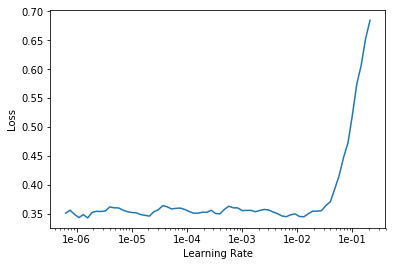

In [460]:
learner.lr_find()
learner.recorder.plot()

In [461]:
learner.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.335985,0.344648,0.884211,00:00
1,0.341553,0.361180,0.894737,00:00
2,0.324818,0.317646,0.894737,00:00
3,0.303112,0.338778,0.910526,00:00
4,0.273876,0.337085,0.910526,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


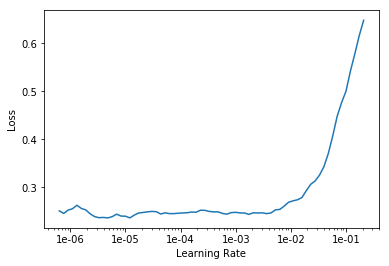

In [462]:
learner.lr_find()
learner.recorder.plot()

In [463]:
learner.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.259076,0.309109,0.905263,00:00
1,0.269149,0.313755,0.900000,00:00
2,0.258992,0.300316,0.905263,00:00
3,0.256819,0.292700,0.894737,00:00
4,0.250668,0.327346,0.900000,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


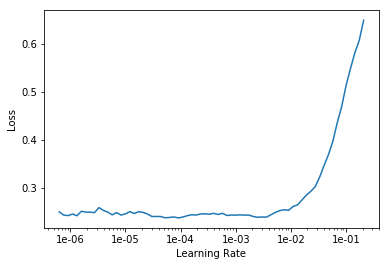

In [464]:
learner.lr_find()
learner.recorder.plot()

In [465]:
learner.fit_one_cycle(5, 5e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.248954,0.283871,0.900000,00:00
1,0.258781,0.306023,0.910526,00:00
2,0.258837,0.299334,0.905263,00:00
3,0.252152,0.321264,0.900000,00:00
4,0.253286,0.296469,0.910526,00:00


In [466]:
val_predictions = np.squeeze(to_np(learner.get_preds(DatasetType.Valid)[0])).argmax(axis=1)

In [467]:
predictions = np.squeeze(to_np(learner.get_preds(DatasetType.Test)[0])).argmax(axis=1)
te['surface'] = predictions
te['surface'] = le.inverse_transform(predictions.round().astype(np.int32))

In [468]:
te[['surface']].to_csv(f'submission_fastai.csv')
te[['surface']].head()

,surface
series_id,
0,tiled
1,carpet
2,tiled
3,carpet
4,soft_tiles


In [469]:
te['surface'].value_counts()

concrete                  961
wood                      820
soft_pvc                  500
fine_concrete             436
tiled                     375
soft_tiles                308
hard_tiles_large_space    246
carpet                    166
hard_tiles                  4
Name: surface, dtype: int64

## Confusion matrix

In [470]:
import itertools

def plot_confusion_matrix(truth, pred, classes, normalize=False, title=''):
    cm = confusion_matrix(truth, pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix', size=15)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.tight_layout()

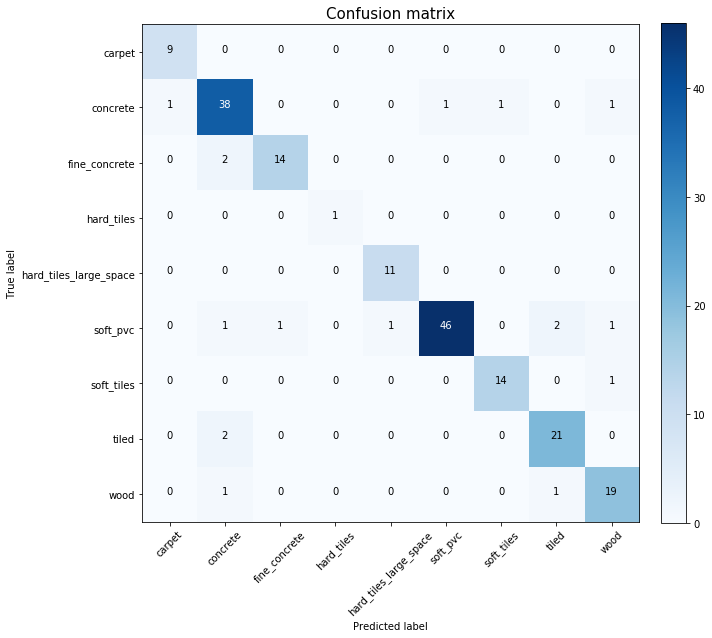

In [471]:
plot_confusion_matrix(tr['surface'].iloc[valid_idx], val_predictions, le.classes_)